## Import libraries for initial data exploration

In [ ]:
#This is an updated version

In [1]:
%matplotlib inline
import matplotlib as mpl;
import matplotlib.pyplot as plt;
import pandas as pd
import zipfile

import numpy as np;
import gzip;
from io import StringIO; 

## Read and visualize an input file

### Provide the root directory for where the user input files are, relative to the notebook location

In [2]:
root_dir = "ExtraSensory.per_uuid_features_labels/"

### File parser helper functions

In [3]:
def parse_header_of_csv(csv_str):
    # Isolate the headline columns:
    headline = csv_str[:csv_str.index(b'\n')];
    columns = headline.split(b',');

    # The first column should be timestamp:
    assert columns[0] == b'timestamp';
    
    # The last column should be label_source:
    assert columns[-1] == b'label_source';
    
    # Search for the column of the first label:
    for (ci,col) in enumerate(columns):
        if col.startswith(b'label:'):
            first_label_ind = ci;
            break;
        pass;

    # Feature columns come after timestamp and before the labels:
    feature_names = columns[1:first_label_ind];
    
    # Then come the labels, till the one-before-last column:
    label_names = columns[first_label_ind:-1];
    for (li,label) in enumerate(label_names):
        
        # In the CSV the label names appear with prefix 'label:', but we don't need it after reading the data:
        assert label.startswith(b'label:');
        label_names[li] = label.replace(b'label:',b'');
        pass;
    
    return (feature_names, label_names);

def parse_body_of_csv(csv_str,n_features):
    # Read the entire CSV body into a single numeric matrix:
    full_table = np.loadtxt(StringIO(csv_str.decode("utf-8")),delimiter=',',skiprows=1);
    
    # Timestamp is the primary key for the records (examples):
    timestamps = full_table[:,0].astype(int);
    
    # Read the sensor features:
    X = full_table[:,1:(n_features+1)];
    
    # Read the binary label values, and the 'missing label' indicators:
    trinary_labels_mat = full_table[:,(n_features+1):-1]; # This should have values of either 0., 1. or NaN
    M = np.isnan(trinary_labels_mat); # M is the missing label matrix
    Y = np.where(M,0,trinary_labels_mat) > 0.; # Y is the label matrix
    
    return (X,Y,M,timestamps);

'''
Read the data (precomputed sensor-features and labels) for a user.
This function assumes the user's data file is present.
'''
def read_user_data(uuid):
    user_data_file = '%s%s.features_labels.csv.gz' % (root_dir, uuid);

    # Read the entire csv file of the user:
    with gzip.open(user_data_file,'rb') as fid:
        csv_str = fid.read();
        pass;
    
    (feature_names,label_names) = parse_header_of_csv(csv_str);
    n_features = len(feature_names);
    (X,Y,M,timestamps) = parse_body_of_csv(csv_str,n_features);

    return (X,Y,M,timestamps,feature_names,label_names);

### Visualize contents of a single input file

In [4]:
uuid = '1155FF54-63D3-4AB2-9863-8385D0BD0A13'

In [5]:
(X, Y, M, timestamps, feature_names, label_names) = read_user_data(uuid);
feature_names = [i.decode("utf-8") for i in feature_names]
label_names = [i.decode("utf-8") for i in label_names]

for idx, feature in enumerate(feature_names):
    print(idx, " ", feature)

0   raw_acc:magnitude_stats:mean
1   raw_acc:magnitude_stats:std
2   raw_acc:magnitude_stats:moment3
3   raw_acc:magnitude_stats:moment4
4   raw_acc:magnitude_stats:percentile25
5   raw_acc:magnitude_stats:percentile50
6   raw_acc:magnitude_stats:percentile75
7   raw_acc:magnitude_stats:value_entropy
8   raw_acc:magnitude_stats:time_entropy
9   raw_acc:magnitude_spectrum:log_energy_band0
10   raw_acc:magnitude_spectrum:log_energy_band1
11   raw_acc:magnitude_spectrum:log_energy_band2
12   raw_acc:magnitude_spectrum:log_energy_band3
13   raw_acc:magnitude_spectrum:log_energy_band4
14   raw_acc:magnitude_spectrum:spectral_entropy
15   raw_acc:magnitude_autocorrelation:period
16   raw_acc:magnitude_autocorrelation:normalized_ac
17   raw_acc:3d:mean_x
18   raw_acc:3d:mean_y
19   raw_acc:3d:mean_z
20   raw_acc:3d:std_x
21   raw_acc:3d:std_y
22   raw_acc:3d:std_z
23   raw_acc:3d:ro_xy
24   raw_acc:3d:ro_xz
25   raw_acc:3d:ro_yz
26   proc_gyro:magnitude_stats:mean
27   proc_gyro:magnitude_sta

In [6]:
print(timestamps)
print(len(timestamps))

[1464129912 1464129950 1464130031 ... 1464887023 1464887322 1464887622]
2685


In [7]:
for idx, label in enumerate(label_names):
    print(idx, " ", label)

0   LYING_DOWN
1   SITTING
2   FIX_walking
3   FIX_running
4   BICYCLING
5   SLEEPING
6   LAB_WORK
7   IN_CLASS
8   IN_A_MEETING
9   LOC_main_workplace
10   OR_indoors
11   OR_outside
12   IN_A_CAR
13   ON_A_BUS
14   DRIVE_-_I_M_THE_DRIVER
15   DRIVE_-_I_M_A_PASSENGER
16   LOC_home
17   FIX_restaurant
18   PHONE_IN_POCKET
19   OR_exercise
20   COOKING
21   SHOPPING
22   STROLLING
23   DRINKING__ALCOHOL_
24   BATHING_-_SHOWER
25   CLEANING
26   DOING_LAUNDRY
27   WASHING_DISHES
28   WATCHING_TV
29   SURFING_THE_INTERNET
30   AT_A_PARTY
31   AT_A_BAR
32   LOC_beach
33   SINGING
34   TALKING
35   COMPUTER_WORK
36   EATING
37   TOILET
38   GROOMING
39   DRESSING
40   AT_THE_GYM
41   STAIRS_-_GOING_UP
42   STAIRS_-_GOING_DOWN
43   ELEVATOR
44   OR_standing
45   AT_SCHOOL
46   PHONE_IN_HAND
47   PHONE_IN_BAG
48   PHONE_ON_TABLE
49   WITH_CO-WORKERS
50   WITH_FRIENDS


In [8]:
Y.shape 

(2685, 51)

In [9]:
X.shape

(2685, 225)

### Visualize raw data

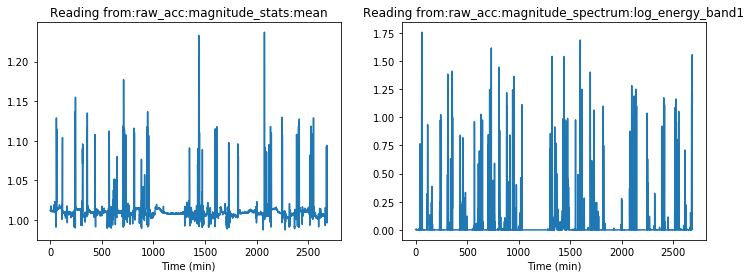

In [10]:
t = [i for i in range(len(X[:,0]))]
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t,X[:,0])
plt.xlabel('Time (min)')
plt.title('Reading from:'+feature_names[0])
plt.subplot(122)
plt.plot(t,X[:,10])
plt.xlabel('Time (min)')
plt.title('Reading from:'+feature_names[10])
plt.show()

## Read and store all the file data

### Now that we've explored the dataset, we can store the rest of the files for processing.

In [11]:
from os import listdir
from os.path import isfile, join
import gzip
import shutil

In [12]:
onlyfiles = [f for f in listdir(root_dir)]
final_files = [] 
for i in onlyfiles: 
    x = '/%s%s' % (root_dir, i[0:len(i)-4]) 
    print(x)
    final_files.append(x)

/ExtraSensory.per_uuid_features_labels/81536B0A-8DBF-4D8A-AC24-9543E2E4C8E0.features_labels
/ExtraSensory.per_uuid_features_labels/61359772-D8D8-480D-B623-7C636EAD0C81.features_labels
/ExtraSensory.per_uuid_features_labels/A7599A50-24AE-46A6-8EA6-2576F1011D81.features_labels.cs
/ExtraSensory.per_uuid_features_labels/78A91A4E-4A51-4065-BDA7-94755F0BB3BB.features_labels.cs
/ExtraSensory.per_uuid_features_labels/11B5EC4D-4133-4289-B475-4E737182A406.features_labels.cs
/ExtraSensory.per_uuid_features_labels/40E170A7-607B-4578-AF04-F021C3B0384A.features_labels
/ExtraSensory.per_uuid_features_labels/CDA3BBF7-6631-45E8-85BA-EEB416B32A3C.features_labels.cs
/ExtraSensory.per_uuid_features_labels/CF722AA9-2533-4E51-9FEB-9EAC84EE9AAC.features_labels.cs
/ExtraSensory.per_uuid_features_labels/5152A2DF-FAF3-4BA8-9CA9-E66B32671A53.features_labels.cs
/ExtraSensory.per_uuid_features_labels/806289BC-AD52-4CC1-806C-0CDB14D65EB6.features_labels
/ExtraSensory.per_uuid_features_labels/A76A5AF5-5A93-4CF2-A16E

In [13]:
# for idx in range(len(final_files)):
#     with gzip.open('.'+final_files[idx]+'.csv.gz', 'rb') as f_in:
#                 with open('.'+final_files[idx]+'.csv', 'wb') as f_out:
#                     shutil.copyfileobj(f_in, f_out)          

### Import Torch Libraries

In [14]:
import torch 
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import seaborn as sns 

### Visualize NaN entries in a sensor reading

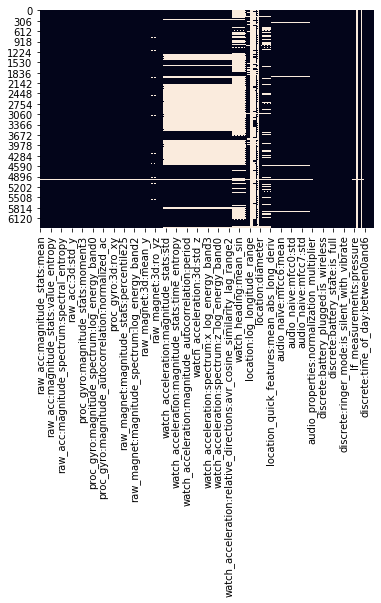

In [15]:
raw_d = pd.read_csv('.' + final_files[0] + '.csv')
sensor_data = raw_d.iloc[:,1:225]

heatmap = sns.heatmap(sensor_data.isnull(), cbar = False)

# for index, row in sensor_data.iterrows():
#     print(row.isnull())

In [16]:
labels_data = raw_d.iloc[:,226:-1]
labels_data.head()

,label:LYING_DOWN,label:SITTING,label:FIX_walking,label:FIX_running,label:BICYCLING,label:SLEEPING,label:LAB_WORK,label:IN_CLASS,label:IN_A_MEETING,label:LOC_main_workplace,...,label:STAIRS_-_GOING_UP,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS
0,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
1,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
2,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
3,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
4,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0


### Fill NaN with column mode, and drop remaining NaN

In [17]:
def remove_and_fill_nan(data):
    data[data.columns] = data[data.columns].fillna(data.mean().iloc[0])
    data.dropna(inplace = True, axis = 'columns' )
    return data
def remove_and_fill_nan_zero(data):
    data[data.columns] = data[data.columns].fillna(0)
    data.dropna(inplace = True, axis = 'columns' )
    return data

sensor_data = remove_and_fill_nan(sensor_data)
labels_data = remove_and_fill_nan_zero(labels_data)

In [18]:
labels_data.head()

,label:LYING_DOWN,label:SITTING,label:FIX_walking,label:FIX_running,label:BICYCLING,label:SLEEPING,label:LAB_WORK,label:IN_CLASS,label:IN_A_MEETING,label:LOC_main_workplace,...,label:STAIRS_-_GOING_UP,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
labels_data.iloc[:10,:].to_numpy().shape

(10, 51)

### Visualize data before normalization

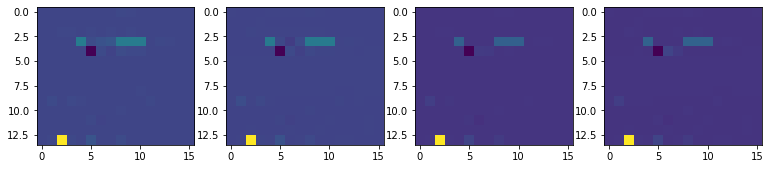

In [20]:
plt.figure(figsize = (13, 6))
plt.title('Unnormalizaed data')
for i in range(4): 
    ax = plt.subplot(1, 4, i+1)
    row_i = sensor_data.iloc[i,:].to_numpy().reshape(14, 16)
    ax.imshow(row_i)

### Normalize the data

In [21]:
def normalize_data(data):
    norm_data = pd.DataFrame() 
    for col in data.columns: 
        col_mean = data[col].mean()
        col_std = data[col].std()
        norm_data[col] = (data[col] - col_mean)/col_std
    
    norm_data.dropna(inplace = True, axis = 'columns' )
    return norm_data

norm_sensor_data = normalize_data(sensor_data)

#  Note the the number of columns has changed from the data set without normalization

### Visualize the data after normalization

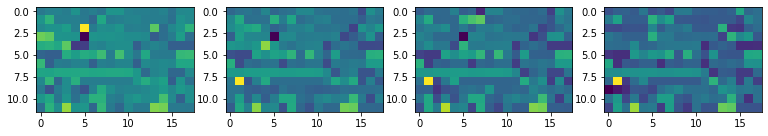

In [22]:
plt.figure(figsize = (13,6))
plt.title('Normalized data')
for i in range(4): 
    ax = plt.subplot(1,4,i+1)
    row_i = norm_sensor_data.iloc[i,:].to_numpy().reshape(12,18)
    plt.imshow(row_i)

### Define helper functions for image manipulation

In [23]:
# Construct 2D image 
def reshape_img(tensor,w,h):
    return tensor.reshape([w,h])

# min-max normalization  
def min_max_norm(tensor, min_value, max_value):
    min_val = tensor.min()
    tensor = (tensor - min_val)
    max_val = tensor.max()
    tensor = tensor / max_val
    tensor = tensor * (max_val - min_val) + min_val
    return tensor 

### Create a SensorDataset class that can be used to store the data

In [24]:
class SensorDataset(Dataset): 
    
    def __init__(self, sensor_data, transform,labels_data):
        """provide directory with the user's data"""
        self.sensor_data = sensor_data
        self.transform = transform
        self.labels_data = labels_data
        
    def __len__(self):
        return len(self.sensor_data)
        
    # This function can be used to index into the dataset
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
                 

        sample =  self.sensor_data.iloc[idx,:]
        labels =  self.labels_data.iloc[idx,:]
        
        if self.transform:
            # Transform to tensor
            sample = self.transform(sample.to_numpy().reshape(12,18))
            
        return sample, torch.from_numpy(labels.to_numpy())

### Define the batch size parameter

In [25]:
batch_size = 20

### Create the training & test datasets

In [37]:
def create_train_test_sets(norm_data,labels=None):
    img_transform = transforms.Compose([
        transforms.ToTensor()])
    #     transforms.Lambda(lambda tensor:min_max_norm(tensor, 0, 1)),
    #     transforms.Lambda(lambda tensor:reshape_img(tensor,11,20))

    dataset_size = len(norm_data)

    # Indexes for 0 -> 2/3 of dataset_size
    row_train = [i for i in range(int(2*dataset_size/3))]
    train_data = norm_data.loc[row_train,:]

    # Indexes for 2/3 dataset_size -> end
    row_test = [i for i in range(int(2*dataset_size/3),dataset_size)] 
    test_data = norm_data.loc[row_test,:]
    
    print(len(train_data))
    print(len(test_data))

    train_data = SensorDataset(train_data, transform = img_transform,labels_data=labels.loc[row_train,:])
    test_data = SensorDataset(test_data, transform = img_transform,labels_data=labels.loc[row_test,:])
    
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle=True)
    
    return train_data, test_data, train_loader, test_loader


In [38]:
train_data, test_data, train_loader, test_loader = create_train_test_sets(norm_sensor_data, labels = labels_data)

4271
2136


In [39]:
len(test_data)

2136

In [40]:
dataset_size = len(norm_sensor_data)
row_test = [i for i in range(int(2*dataset_size/3),dataset_size)] 
norm_sensor_data.loc[row_test,:]

,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,raw_acc:magnitude_spectrum:log_energy_band0,...,lf_measurements:battery_level,lf_measurements:screen_brightness,lf_measurements:temperature_ambient,discrete:time_of_day:between0and6,discrete:time_of_day:between3and9,discrete:time_of_day:between6and12,discrete:time_of_day:between9and15,discrete:time_of_day:between12and18,discrete:time_of_day:between15and21,discrete:time_of_day:between18and24
4271,-1.617296e-01,-0.380291,-0.327329,-0.481530,0.349929,-0.039669,-0.283798,0.719219,0.107826,0.108900,...,1.136442,-0.999922,-0.474976,1.701984,1.796814,-0.534534,-0.566552,-0.576164,-0.583613,-0.611033
4272,-1.925234e-01,-0.383976,-0.341676,-0.485432,0.336927,-0.067830,-0.299003,0.773126,0.107827,0.110674,...,1.136442,-0.999922,-0.520734,1.701984,1.796814,-0.534534,-0.566552,-0.576164,-0.583613,-0.611033
4273,-1.809339e-01,-0.305958,-0.591244,-0.141551,0.345267,-0.039917,-0.284052,-2.941601,0.107701,0.109791,...,1.136442,-0.999922,-0.548610,1.701984,1.796814,-0.534534,-0.566552,-0.576164,-0.583613,-0.611033
4274,-1.951979e-01,-0.382600,-0.343973,-0.483420,0.334163,-0.067233,-0.299691,0.453384,0.107827,0.111528,...,1.136442,-0.999922,-0.545840,1.701984,1.796814,-0.534534,-0.566552,-0.576164,-0.583613,-0.611033
4275,-4.947519e-02,0.454412,0.730393,1.054677,0.315849,-0.081661,-0.290473,-1.882598,0.097201,0.085503,...,1.136442,-0.999922,-0.530662,1.701984,1.796814,-0.534534,-0.566552,-0.576164,-0.583613,-0.611033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6402,-1.315439e+00,0.101827,0.120398,0.133140,-1.141527,-2.009048,-0.407904,-0.070734,0.103919,0.117747,...,-0.480432,-0.999922,-0.139142,-0.587458,-0.556454,1.870495,1.764789,-0.576164,-0.583613,-0.611033
6403,-2.474403e-14,7.271618,7.165891,5.452324,0.479396,0.187854,-0.233337,-1.447698,-9.951389,-9.944707,...,1.215638,-0.999922,-5.541178,-0.587458,-0.556454,1.870495,1.764789,-0.576164,-0.583613,-0.611033
6404,-7.232616e-01,0.516906,0.167645,0.532777,-1.868185,-1.143022,0.460011,0.276337,0.094775,0.097328,...,-0.542619,-0.999922,-0.198222,-0.587458,-0.556454,1.870495,1.764789,-0.576164,-0.583613,-0.611033
6405,-1.051110e+00,0.207818,-0.091478,0.191980,-1.380470,-1.180089,0.058977,0.406254,0.102045,0.103367,...,-0.573713,-0.999922,0.093042,-0.587458,-0.556454,1.870495,1.764789,-0.576164,-0.583613,-0.611033


## Visualize the training data as images

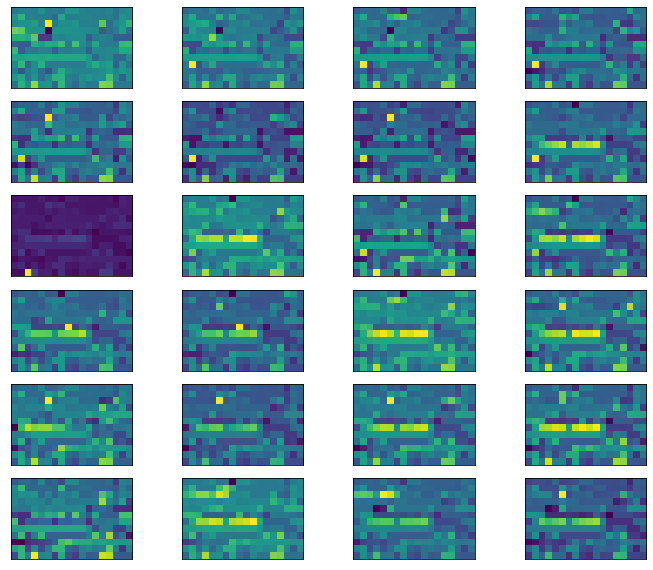

In [42]:
fig = plt.figure(figsize=(10, 8))
count = 0 
for i in range(24):
    ax = plt.subplot(6,4,count+1)
    
    im = train_data[count][0]
    ax.set_xticks([]) 
    ax.set_yticks([])
    plt.imshow(im.numpy().squeeze())
    count +=1
    
fig.tight_layout(pad=1.0)

## Process the data with an Autoencoder

### Initialize the Autoencoder variables and hyperparameters

In [43]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Create Autoencoder class

In [44]:
class Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=kwargs["input_shape"],out_features=100),
            nn.ReLU(True),
            nn.Linear(100, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 100),
            nn.ReLU(True),
            nn.Linear(in_features= 100, out_features=kwargs["input_shape"]))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    def forward_encoder_only(self,x):
        return self.encoder(x)

In [45]:
# class Autoencoder_EncodeOnly(nn.Module):
#     def __init__(self, **kwargs):
#         super().__init__()
        
#         self.encoder = nn.Sequential(
#             nn.Linear(in_features=kwargs["input_shape"],out_features=100),
#             nn.ReLU(True),
#             nn.Linear(100, 64),
#             nn.ReLU(True))
#         self.decoder = nn.Sequential(
#             nn.Linear(64, 100),
#             nn.ReLU(True),
#             nn.Linear(in_features= 100, out_features=kwargs["input_shape"]))

#     def forward(self, x):
#         x = self.encoder(x)
#         return x

### Leverage GPU, if available

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Define the input shape

In [62]:
input_shape = 216
input_shape_s1 = 12
input_shape_s2 = 18

### Create an autoencoder instance

In [49]:
model = Autoencoder(input_shape = input_shape).to(device)

## Train the autoencoder

### Define the `fit()` method
#### Accepts the # of epochs (`num_epochs`) and learning rate (`learn_rate`) as parameters

In [54]:
def fit(num_epochs, learn_rate):
    loss_array = []
    
    # create an optimizer object
    # Adam optimizer with learning rate
    optimizer = optim.Adam(model.parameters(), lr = learn_rate)
    
    # Define the loss function
    criterion = nn.MSELoss()
    
    for epoch in range(num_epochs):
        loss = 0
        count = 0
        
        for batch_features,_ in train_loader:
            # reshape mini-batch data to [N, input_shape] matrix
            # load it to the active device
            batch_features = batch_features.view(-1, input_shape).to(device)

            # plt.imshow(batch_features.numpy().squeeze())
            # plt.show()

            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()

            # compute reconstructions
            outputs = model(batch_features.float())

            # compute training reconstruction loss
            train_loss = criterion(outputs, batch_features.float())

            # compute accumulated gradients
            train_loss.backward()

            # perform parameter update based on current gradients
            optimizer.step()

            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()

        # compute the average training loss across the epoch
        loss = loss / len(train_loader)
        loss_array.append(loss)

        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, num_epochs, loss)) 
    return loss_array

### Run the autoencoder once, to visualize the results

In [66]:
loss_results = fit(num_epochs = 40, learn_rate = 1e-3)

epoch : 1/40, loss = 0.275214
epoch : 2/40, loss = 0.273842
epoch : 3/40, loss = 0.281816
epoch : 4/40, loss = 0.259395
epoch : 5/40, loss = 0.273493
epoch : 6/40, loss = 0.249585
epoch : 7/40, loss = 0.248712
epoch : 8/40, loss = 0.250827
epoch : 9/40, loss = 0.251141
epoch : 10/40, loss = 0.267557
epoch : 11/40, loss = 0.251382
epoch : 12/40, loss = 0.248083
epoch : 13/40, loss = 0.249774
epoch : 14/40, loss = 0.247647
epoch : 15/40, loss = 0.235066
epoch : 16/40, loss = 0.227307
epoch : 17/40, loss = 0.240240
epoch : 18/40, loss = 0.231216
epoch : 19/40, loss = 0.239964
epoch : 20/40, loss = 0.236475
epoch : 21/40, loss = 0.229829
epoch : 22/40, loss = 0.239213
epoch : 23/40, loss = 0.238339
epoch : 24/40, loss = 0.224963
epoch : 25/40, loss = 0.223725
epoch : 26/40, loss = 0.234621
epoch : 27/40, loss = 0.217253
epoch : 28/40, loss = 0.212257
epoch : 29/40, loss = 0.233931
epoch : 30/40, loss = 0.207237
epoch : 31/40, loss = 0.211060
epoch : 32/40, loss = 0.210269
epoch : 33/40, lo

### Visualize how loss changes with # of epochs for training data 

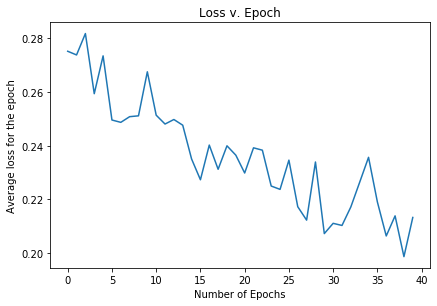

In [79]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
fig.tight_layout()
ax1.plot(loss_results)
plt.xlabel("Number of Epochs")
plt.ylabel("Average loss for the epoch")
plt.title("Loss v. Epoch")
plt.show()

## Test the dataset

In [68]:
test_examples = None
reconstruction = None

with torch.no_grad():
    for batch_features,_ in test_loader:
        test_examples = batch_features.view(-1, input_shape)
        reconstruction = model(test_examples.float())
        break

### Visualize the results

In [69]:
print(test_examples.shape)
print(reconstruction.shape)

torch.Size([20, 216])
torch.Size([20, 216])


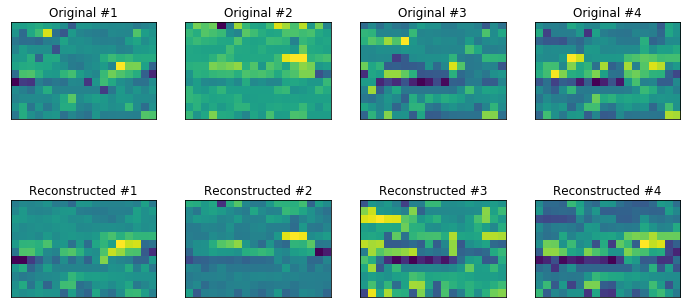

In [70]:
with torch.no_grad():
    number = 4
    plt.figure(figsize=(12, 6))
    for index in range(number):
        
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(input_shape_s1, input_shape_s2))
        plt.title('Original #' + str(index + 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display reconstructed
        ax = plt.subplot(2, number, index + 1+ number)
        plt.imshow(reconstruction[index].numpy().reshape(input_shape_s1, input_shape_s2))
        plt.title('Reconstructed #' + str(index + 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  

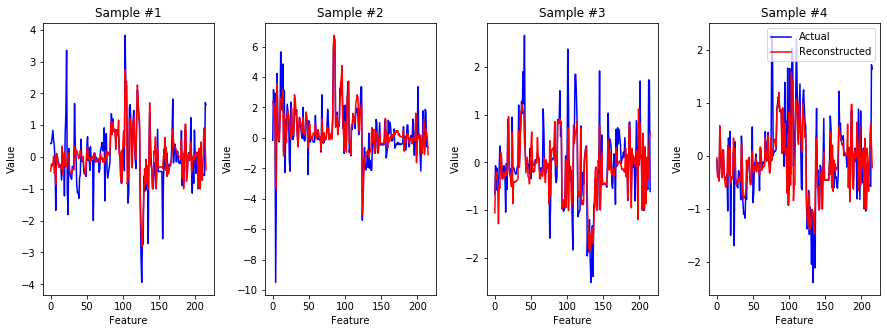

In [78]:
t = [i for i in range(input_shape)]
count = 0 
with torch.no_grad():
    number = 4
    fig, axes = plt.subplots(1, number, figsize=(15, 5))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)
    for index in range(number):
        # display original
        ax = plt.subplot(1, number, index + 1)
        sensor_read = test_examples[index].numpy().reshape(input_shape, 1)
        plt.title('Sample #' + str(index + 1))
        plt.xlabel('Feature')
        plt.ylabel('Value')
        plt.subplot(ax)
        plt.plot(t, sensor_read, color = 'b', label = 'Actual')

        sensor_read_rec = reconstruction[index].numpy().reshape(input_shape, 1)
        plt.plot(t, sensor_read_rec, color = 'r', label = 'Reconstructed'); 

plt.legend(loc ='best')
plt.show() 

# Run the Autoencoder logic for all the files

In [39]:
encoded_vals = [j for j in range(len(final_files))]
count = 0
labels_shape = 226
for file in final_files:
    if (file.endswith('.cs')):
        continue
       
    raw_d = pd.read_csv('.' + file + '.csv')
    
    sensor_data = raw_d.iloc[:,1:input_shape+1]
    sensor_data = remove_and_fill_nan(sensor_data)
    labels_data = raw_d.iloc[:,labels_shape:-1]
    labels_data = remove_and_fill_nan_zero(labels_data)
    norm_sensor_data = normalize_data(sensor_data)
    train_data_set, test_data_set, train_dataset_loader, test_dataset_loader = create_train_test_sets(norm_sensor_data,labels_data)
    
    # Use the Autoencoder that only encodes
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Autoencoder_EncodeOnly(input_shape = input_shape).to(device)
    
    # Use the Autoencoder that both encodes and decodes
    # model = Autoencoder(input_shape = input_shape).to(device)
    
    # loss_results = fit(num_epochs = 20, learn_rate = 1e-3)
    
    i = 0
    reconstruction = [[] for i in range(len(test_dataset_loader))]
    with torch.no_grad():
        for batch_features in test_dataset_loader:
            test_examples = batch_features.view(-1, input_shape)
            reconstruction[i] = model(test_examples.float())
            break
    
    encoded_vals[count] = model(test_examples.float())
    count += 1

print(encoded_vals[0])

tensor([[0.2526, 0.0000, 0.0000,  ..., 0.0000, 0.1187, 0.0000],
        [0.3936, 0.0000, 0.1353,  ..., 0.0000, 0.1110, 0.0000],
        [0.2099, 0.0000, 0.0226,  ..., 0.0786, 0.0000, 0.0000],
        ...,
        [0.1438, 0.0000, 0.0000,  ..., 0.0000, 0.1134, 0.0000],
        [0.3498, 0.0000, 0.0000,  ..., 0.5206, 1.2192, 0.7647],
        [0.2082, 0.0000, 0.0000,  ..., 0.0632, 0.1259, 0.0031]],
       grad_fn=<ReluBackward1>)
